<h1 align='center'><strong>SENTIMENT ANALYSIS FOR A MOVIE STREAMING COMPANY</dtrong></h1>

***

<a src=https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis><p>DATASET SOURCE</p></a>
<p>Farid Rahimli</p>
<p>GH1029730</p>
<p>M508B Big Data Analytics</p>

***

<h2 align='center'><strong>1. PROBLEM STATEMENT</strong></h2>

***

***

<h3 align='center'><strong>PROBLEM</strong></h3>
<h4>our newly incorporated movie streaming company just released a platform for movies streaming. In order to provide efficient movie recommendations as well as to create "Popular" and "Top" movies section understanding quality of the film based on customer review is essential. Moreover, it is usually not possible to manually scan the reviews as man-hours would be extensive therefore, increasing labor cost which is not beneficial for the company.</h4>

***

***

<h3 align='center'><strong>SOLUTION/OBJECTIVE</strong></h3>
<h4>In order to eliminate this problem sentiment analysis will have to be implemented. By collecting large annotated dataset with customer reviews we can use NLP processes to create a pipeline which will automate the process of understanding if the review is negative or positive. Doing this will not only improve cost effectiveness it will improve timeliness and eliminate human error. Moreover, by implementing sentiment analysis possibility of identifying which movies to add in future will be beneficial. </h4>

***

***

<h2 align='center'><strong>2. DATA COLLECTION/INSPECTION</strong></h2>

***

***

<h3 align='center'><strong>DATA</strong></h3>
<h4>We will implement annotated IMDB movie reviews dataset to procure a model that can identify and automatically label movie reviews and assign either 1 or 0 for positive and negative. Data will be inspected, cleaner preprocessed and feature engineering will be done on the data. Getting the data ready for the input to the model is crucial in the NLP pipeline. Reviews from IMDB Dataset is chosen due the similar nature of the reviews as our company has a movie streaming business model in mind. Due to lack of initial data locally using publicly available IMDB dataset will introduce preliminary data for model training</h4>

***

***

<h2 align='center'><strong>3. HIGH LEVEL SYSTEM DESIGN</strong></h2>

***

![Image Description](./hld.jpg)

***

<h2 align='center'><strong>4. IMPLEMENTATION</strong></h2>

***

In [40]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import seaborn as sns
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\ASUS
[nltk_data]     ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

***
* ### *Necessary libraries are imported*
* ### *Libraries for data inspection, preprocessing, feature engineering, modelling and visualization*
***

In [3]:
df = pd.read_csv('movie.csv')

***
* ### *Data is loaded*
***

In [4]:
df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


***
* ### *As can be seen the data consists of 2 important to us columns*
* ### *"text" which provides the reviews*
* ### "label" which provides the annotations for the respective reviews
***

<Axes: >

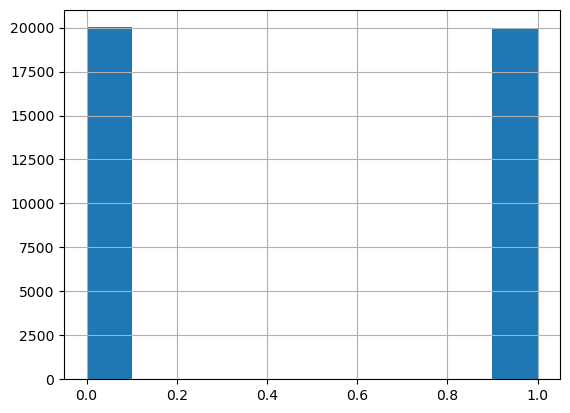

In [5]:
df['label'].hist()

***
* ### *In order to ensure robust and precise ensuring classes are balanced is essential*
* ### *As we can see dataset has perfect class distribution classes are balanced perfectly*
***

In [6]:
print(df.shape)

(40000, 2)


***
* ### *Further, inspection of the shape of the dataset shows*
* ### *40000 data-points are present in the dataset with only 2 columns*
***

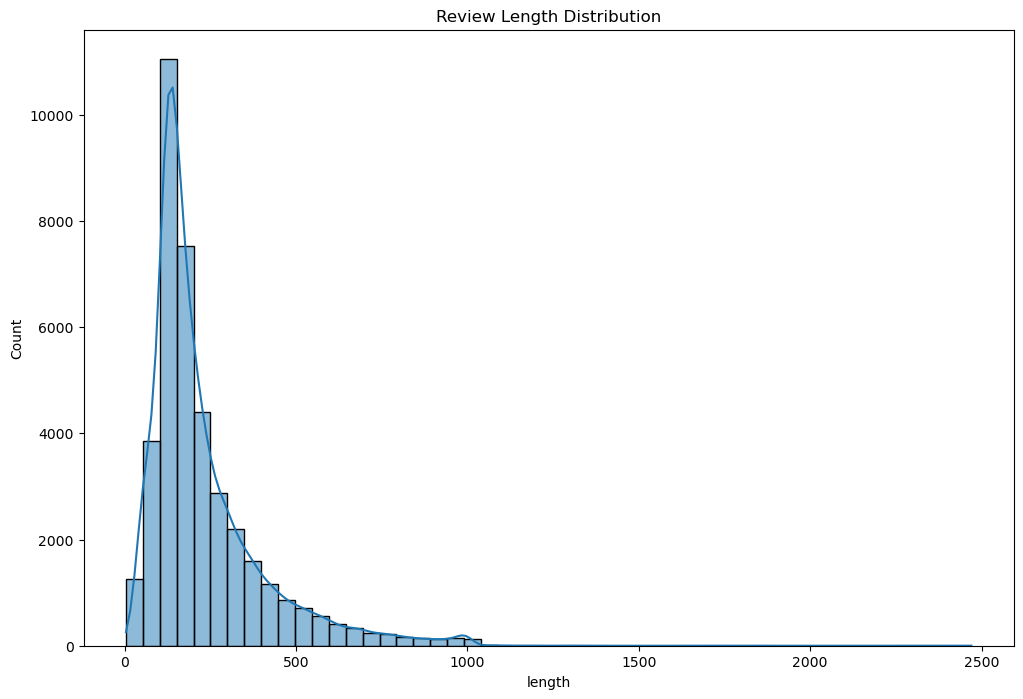

In [7]:
df['length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,8))
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.show()

***
* ### *For explanatory purposes the length distribution of reviews is shown*
* ### *It is evident that highest number of reviews are around 250 characters long*
* ### *Minimal amount are around 1100 characters longs*
* ### *Around 1500 are extremely short therefore, they provide minimal information*
***

In [8]:
texts = list(df['text'])
texts[:3]

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping 

***
* ### *For ease of use as there are no additional features*
* ### *Dataset is converted into the list*
* ### *First 4 items are shown*
* ### *It can be seen that certain reviews have artifacts that will have to be handled further*
* ### *For example there are some html tags present*
***

In [9]:
labels = list(df['label'])
labels[:3]

[0, 0, 0]

***
* ### *Labels are shown for the completeness*
***

***

<h2 align='center'><strong>4.1. DATA PREPROCESSING</strong></h2>

***

In [10]:
stpw = set(stopwords.words('english'))

***
* ### *In order to clean the reviews from unneeded words*
* ### *Stopwords array is initialized from nltk stopword corpus*
***

In [11]:
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

***
* ### *Lemmatizer is initialized as well for future use which will to disassemble words to their roots*
***

In [12]:
def cleaner(data_html):
	soup = BeautifulSoup(data_html, 'html.parser')
	return soup.get_text()

***
* ### *As was mentioned previously there are html tags present*
* ### *Although there is no data scraping beatifulsoup library is prefect for html tag removal*
***

In [13]:
def punct_cleaning(data):
	data = re.sub(r'\S*@\S*\s?', '', data)
	data = re.sub(r'\s+', ' ', data)
	data = re.sub(r'[^a-zA-Z]', ' ',data)
	return data

***
* ### *In order to clean the reviews removing any email artifacts is important*
* ### *Further, extra white space is removed to ensure consistency*
* ### *All numbers are removed further, to just have letter information*
***

In [14]:
def preprocessing(data):
	data = punct_cleaning(data)
	data = cleaner(data)
	toks = word_tokenize(data.lower())
	toks = [lemma.lemmatize(i) for i in toks if i.isalpha() and i not in stpw]
	toks = [stemmer.stem(i) for i in toks]
	return " ".join(toks)

***
* ### *Data preprocessing is done as a function for ease of use*
* ### *Initially previously defined beatifulsoup function is applied to the reviews array*
* ### *Further tokenization is applied followed by lowering the case of letters*
* ### *lemmataztion and filtering all alphabet characters that are not present in stopwords list*
* ### *Finally output is joined and presented as an array*
***

In [15]:
cleaned_texts = [preprocessing(i) for i in texts]

***
* ### *Previously defined function is applied to all reviews in the array*
***

In [16]:
cleaned_texts[:3]

['grew b watch love thunderbird mate school watch play thunderbird school lunch school want virgil scott one want alan count becam art form took child see movi hope would get glimps love child bitterli disappoint high point snappi theme tune could compar origin score thunderbird thank earli saturday morn one televis channel still play rerun seri gerri anderson wife creat jonatha frake hand director chair version complet hopeless wast film utter rubbish cgi remak may accept replac marionett homo sapien subsp sapien huge error judgment',
 'put movi dvd player sat coke chip expect hope movi would contain strong point first movi awsom anim good flow stori excel voic cast funni comedi kick as soundtrack disappoint found atlanti milo return read review first might let follow paragraph direct seen first movi enjoy primarili point mention br br first scene appear shock pick atlanti milo return display case local videoshop whatev expect music feel bad imit first movi voic cast replac fit one ex

***
* ### *First 4 items of the reviews array is shown*
* ### *It can be seen that all letters are lowercased and unnecessary words and punctuation have been removed*
* ### *html tags are removed as well*
* ### *All tokens have been stemmed*
***

In [17]:
df['cleaned_text'] = cleaned_texts

***
* ### *Cleaned reviews are added back to the dataframe*
* ### *This is done to engineer certain features*
***

***

<h2 align='center'><strong>4.2. FEATURE ENGINEERING</strong></h2>

***

In [18]:
sids = SentimentIntensityAnalyzer()

In [19]:
scaler = MinMaxScaler()

***
* ### *Sentiment intensity score is initialized from pre-trained VADER model from nltk*
***

In [20]:
df['sent_score'] = df['cleaned_text'].apply(lambda x: sids.polarity_scores(x)['compound'])

In [21]:
df['sent_score'] = scaler.fit_transform(df[['sent_score']])

***
* ### *New column is created with sentiment intensity scores of cleaned text*
* ### *This will help the model to classify the reviews into classes*
***

In [22]:
df['cleaned_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

***
* ### *Length of the cleaned text are added as a feature as well*
* ### *This will help to visualize the intensity of cleaning*
* ### *As well as introduce new feature for the model*
***

In [23]:
df

,text,label,length,cleaned_text,sent_score,cleaned_length
0,I grew up (b. 1965) watching and loving the Th...,0,151,grew b watch love thunderbird mate school watc...,0.979091,85
1,"When I put this movie in my DVD player, and sa...",0,326,put movi dvd player sat coke chip expect hope ...,0.985443,163
2,Why do people who do not know what a particula...,0,184,peopl know particular time past like feel need...,0.077685,95
3,Even though I have great interest in Biblical ...,0,69,even though great interest biblic movi bore de...,0.206893,33
4,Im a die hard Dads Army fan and nothing will e...,1,178,im die hard dad armi fan noth ever chang got t...,0.776549,106
...,...,...,...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,541,western union someth forgotten classic western...,0.993497,294
39996,This movie is an incredible piece of work. It ...,1,50,movi incred piec work explor everi nook cranni...,0.289130,27
39997,My wife and I watched this movie because we pl...,0,168,wife watch movi plan visit sicili stromboli so...,0.922265,103
39998,"When I first watched Flatliners, I was amazed....",1,168,first watch flatlin amaz necessari featur good...,0.879096,95


In [24]:
x_train, x_test, y_train ,y_test = train_test_split(df[['cleaned_text', 'sent_score', 'cleaned_length']], labels, test_size=0.2, random_state=34)

***
* ### *The data is split all columns that are extension of cleaned reviews are chosen for training*
* ### *Test size is set at 20%*
* ### *Random state is set for reproducibility and to get similar shuffle on each re run*
***

In [25]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

***
* ### *Tfidf vectorizer is initialized*
* ### *n-grams are set to be 1 to 2*
***

In [26]:
x_train_tf = tf_vectorizer.fit_transform(x_train['cleaned_text'])
x_test_tf = tf_vectorizer.transform(x_test['cleaned_text'])

***
* ### *Tfidf vectorizer is used to extract features*
* ### *It is trained on training set*
* ### *Test set is only transformed*
***

***

<h2 align='center'><strong>4.3. MODEL TRAINING</strong></h2>

***

In [27]:
m_param_grid = {
	'alpha' : [1.0, 2.0,3.0,4.0],
	'force_alpha' : [True, False],
	'fit_prior' : [True, False]
}

***
* ### *Parameter dictionary is initialized for the experimentation*
* ### *Hyperparameters of MultinomialNB are set to introduce variety*
***

In [28]:
m_model = MultinomialNB()

***
* ### *Model use will be Naive Bayes multinomial algorithm*
***

In [29]:
m_grid_search = GridSearchCV(m_model, param_grid=m_param_grid, cv=5, n_jobs=-1, verbose=1)

***
* ### *Gridsearch is initalied with 5 validation folds*
* ### *n_jobs is set to -1 to use all cpu cores*
* ### *Verbose is set to 1 to see total fit count*
***

In [30]:
m_grid_search.fit(x_train_tf, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1.0, 2.0, 3.0, 4.0],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             verbose=1)

***
* ### *Total of 80 fits were done*
***

In [31]:
m_grid_search.best_params_

{'alpha': 1.0, 'fit_prior': False, 'force_alpha': True}

***
* ### *It can be seen that best parameters are default parameters*
***

In [32]:
m_grid_search.best_score_

0.8825

***
* ### *The best cross-validation score was 88%*
* ### *Which is applicable and show good training*
***

In [33]:
best_model = MultinomialNB(alpha=1.0, fit_prior=False, force_alpha=True)

***
* ### *After gridsearch experimentation we have the best parameters to proceed*
* ### *Although, parameters are default it is still beneficial to understand that default parameters are the best*
***

In [34]:
best_model.fit(x_train_tf, y_train)

MultinomialNB(fit_prior=False, force_alpha=True)

***
* ### *Best model is fitted with cleaned data and labels*
***

In [35]:
pred = best_model.predict(x_test_tf)

***
* ### *Prediction is done on the test set*
***

***

<h2 align='center'><strong>5. EVALUATION</strong></h2>

***

In [42]:
print("Accuracy Score:", accuracy_score(y_test, pred))

Accuracy Score: 0.885


***
* ### *It can be seen that accuracy is at 88% which is applicable for the task*
***

In [43]:
print("\nClassification Report:\n", classification_report(y_test,pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      4048
           1       0.89      0.88      0.88      3952

    accuracy                           0.89      8000
   macro avg       0.89      0.88      0.88      8000
weighted avg       0.89      0.89      0.88      8000



***
* ### *Perofrmance of the training shows good distribution of precision and recall*
* ### *Precision is important as we have to eliminate Negative positives and positive negatives*
***

In [38]:
cm = confusion_matrix(y_test, pred)

***
* ### *It is important to understand what is the ratio between actual and predicted values*
* ### *Confusion Matrix will show how many true negative positive and negative positives and negatives our model predicts*
***

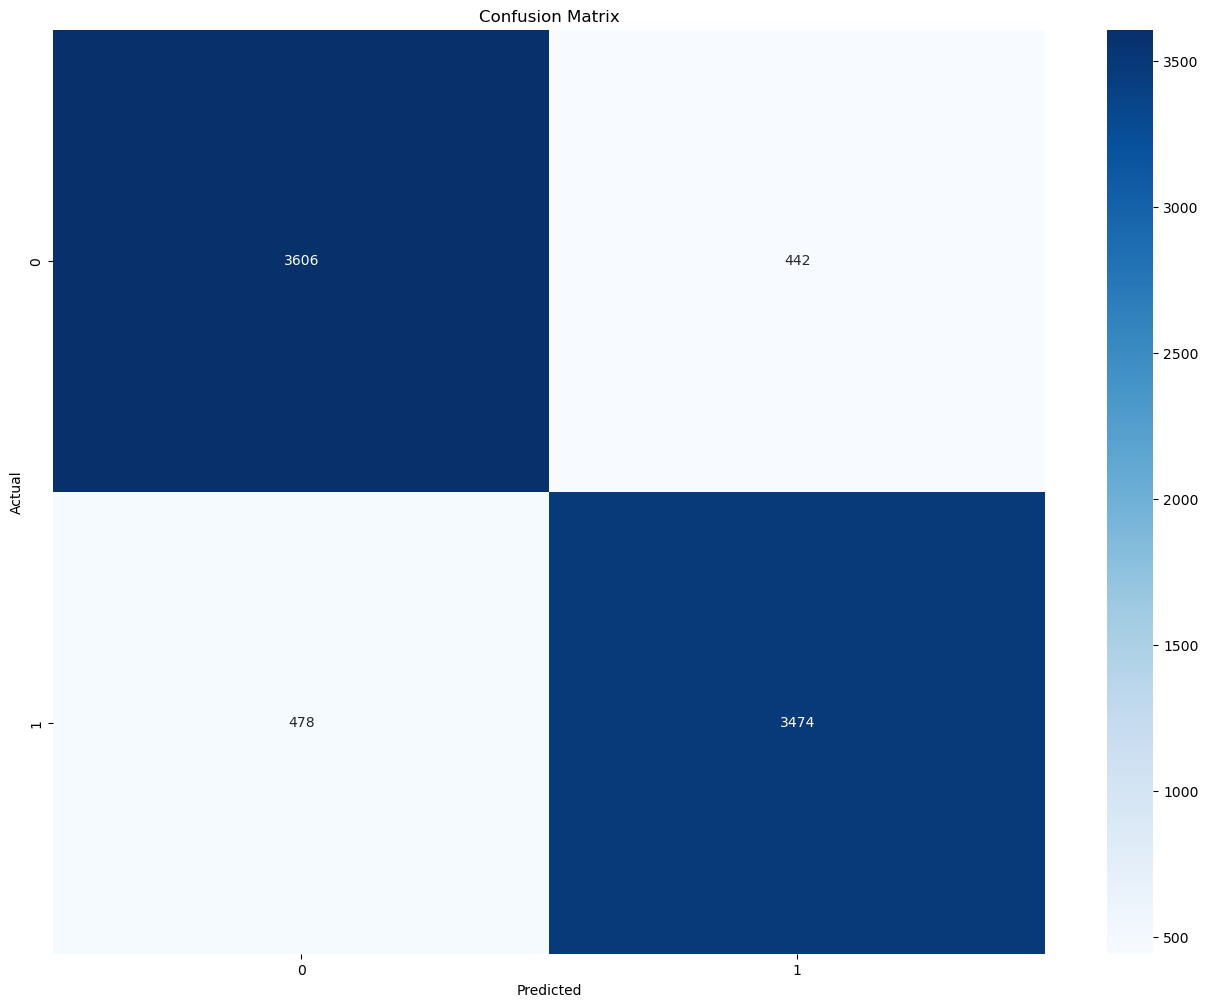

In [39]:
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

***
* ### *As it can be seen 3606 True Positives are predicted which is good*
* ### *Only 422 False positives are predicted which shows good precision*
* ### *About the same is for the negatives*
***

***

<h2 align='center'><strong>6. FINAL DISCUSSION</strong></h2>

***

***

<h3 align='center'><strong>STRENGTH</strong></h3>
<ul>
<li><h4>High accuracy of 88% at classification will provide relevant and quality assessments on the reviews.</h4></li>
<li><h4>Due to the simplicity of the model efficiency and timeliness will be conserved in the future as data volume increases.</h4></li>
<li><h4>Limited bias in the model will provide human subjectiveness.</h4></li>
<li><h4>Very balanced dataset eliminates previously mentioned bias</h4></li>
</ul>

***

***

<h3 align='center'><strong>LIMITATIONS</strong></h3>
<ul>
<li><h4>More complex language will throw off the model as the model is simple</h4></li>
<li><h4>Binary classification is unreliable due to the available dataset not having neutral class some reviews might be misclassified</h4></li>
<li><h4>Due to being traditional algorithm model is highly dependant on the training data quality and distribution</h4></li>
<li><h4>Cant capture trends due to the limitation mentioned previously</h4></li>
</ul>

***

***

<h3 align='center'><strong>BUSINESS IMPACT</strong></h3>
<h4></h4>

***

***

<ul>
<li><h4>User experience can be improved due to availability of information on the sentiments therefore, section such as popular and top are possible to implement and automate</h4></li>
<li><h4>Recommendations will be possible to implement based on two factors such as users frequently watched movies and the sentiment labels to respective movies</h4></li>
<li><h4>Furthermore, recommendation will enable more user inflow as interest will peak</h4></li>
<li><h4>NLP will improve competitive advantage of the company due to better user experience therefore, satisfaction as well as in decreasing labor cost due to automation</h4></li>

</ul>

***

***

<h3 align='center'><strong>RECOMMENDATIONS</strong></h3>
<h4></h4>

***

***

<ul>
<li><h4>Improve the model by adding more classes multi-class classification will improve the generalization of the model as well as improve accuracy and grasp</h4></li>
<li><h4>Create a real-time analysis that will grab new reviews and label them automatically</h4></li>
<li><h4>Use deep-learning models to capture more complex relationships making the model complex and accurate</h4></li>
<li><h4>Introduce multi language support for the model to be able to use model on reviews in multiple languages</h4></li>
<li><h4>Create looping system that will collect the feedback on the recommendations and improve the model especially deep-learning model</h4></li>

</ul>

***